In [35]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make a Mock ECO Survey

In [36]:
# get path to mocks

import os
cwd = os.getcwd()
data_path = os.path.abspath(os.path.join(os.path.dirname(cwd), 'mocks')) + '/'

In [37]:
# open a mock

from astropy.table import Table
mock = Table.read(data_path + 'mock_1a.hdf5', path='data')

In [38]:
# get a ra, dec, redshift survey
# randomly centered and oriented within the PBC cube

from eco_mocks.utils import random_survey
new_mock = random_survey(mock)

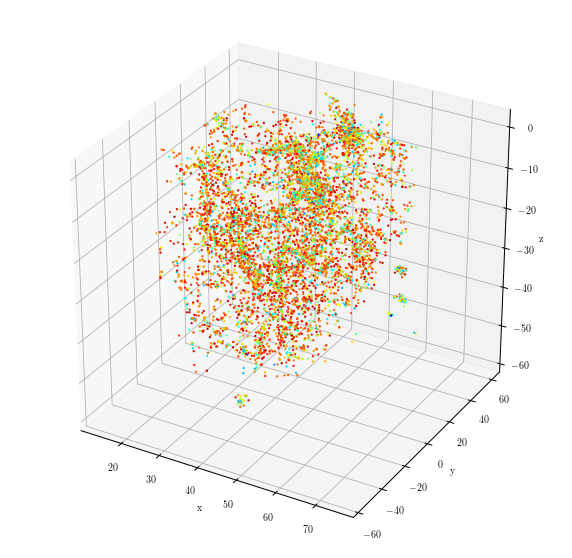

In [39]:
# plot 3d distribution of galaxies

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_mock['x'], new_mock['y'], new_mock['z'],
           c=new_mock['u_minus_r'], alpha=1, lw=0, s=5, cmap='jet_r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

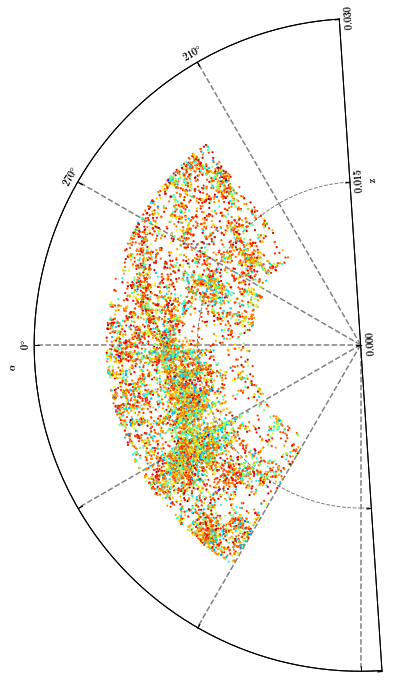

In [40]:
# plot wedge

from eco_mocks.utils import fractional_polar_axes

fig = plt.figure(figsize=(3.3*2, 6.6*2))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.85)
ax = fractional_polar_axes(fig, rlim=(0,0.03),thlim=(93.75,273.75))
ax.grid(True)
ra = new_mock['ra']+180.0
z = new_mock['redshift']
c = new_mock['u_minus_r']
ax.scatter(ra, z, c=c, marker='.', lw=0, s=20,alpha=1,\
           cmap='jet_r', rasterized=True)
plt.show()